In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from datetime import datetime
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

__load in the csv binned daily container volume data__

In [7]:
train = pd.read_csv('Data/daily_binned/xiamen_container_volume_total.csv')

In [8]:
train['Date'] = pd.to_datetime(train.Date,infer_datetime_format=True)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609 entries, 0 to 1608
Data columns (total 2 columns):
Date     1609 non-null datetime64[ns]
Count    1609 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 25.2 KB


__Plot the data for visualization__

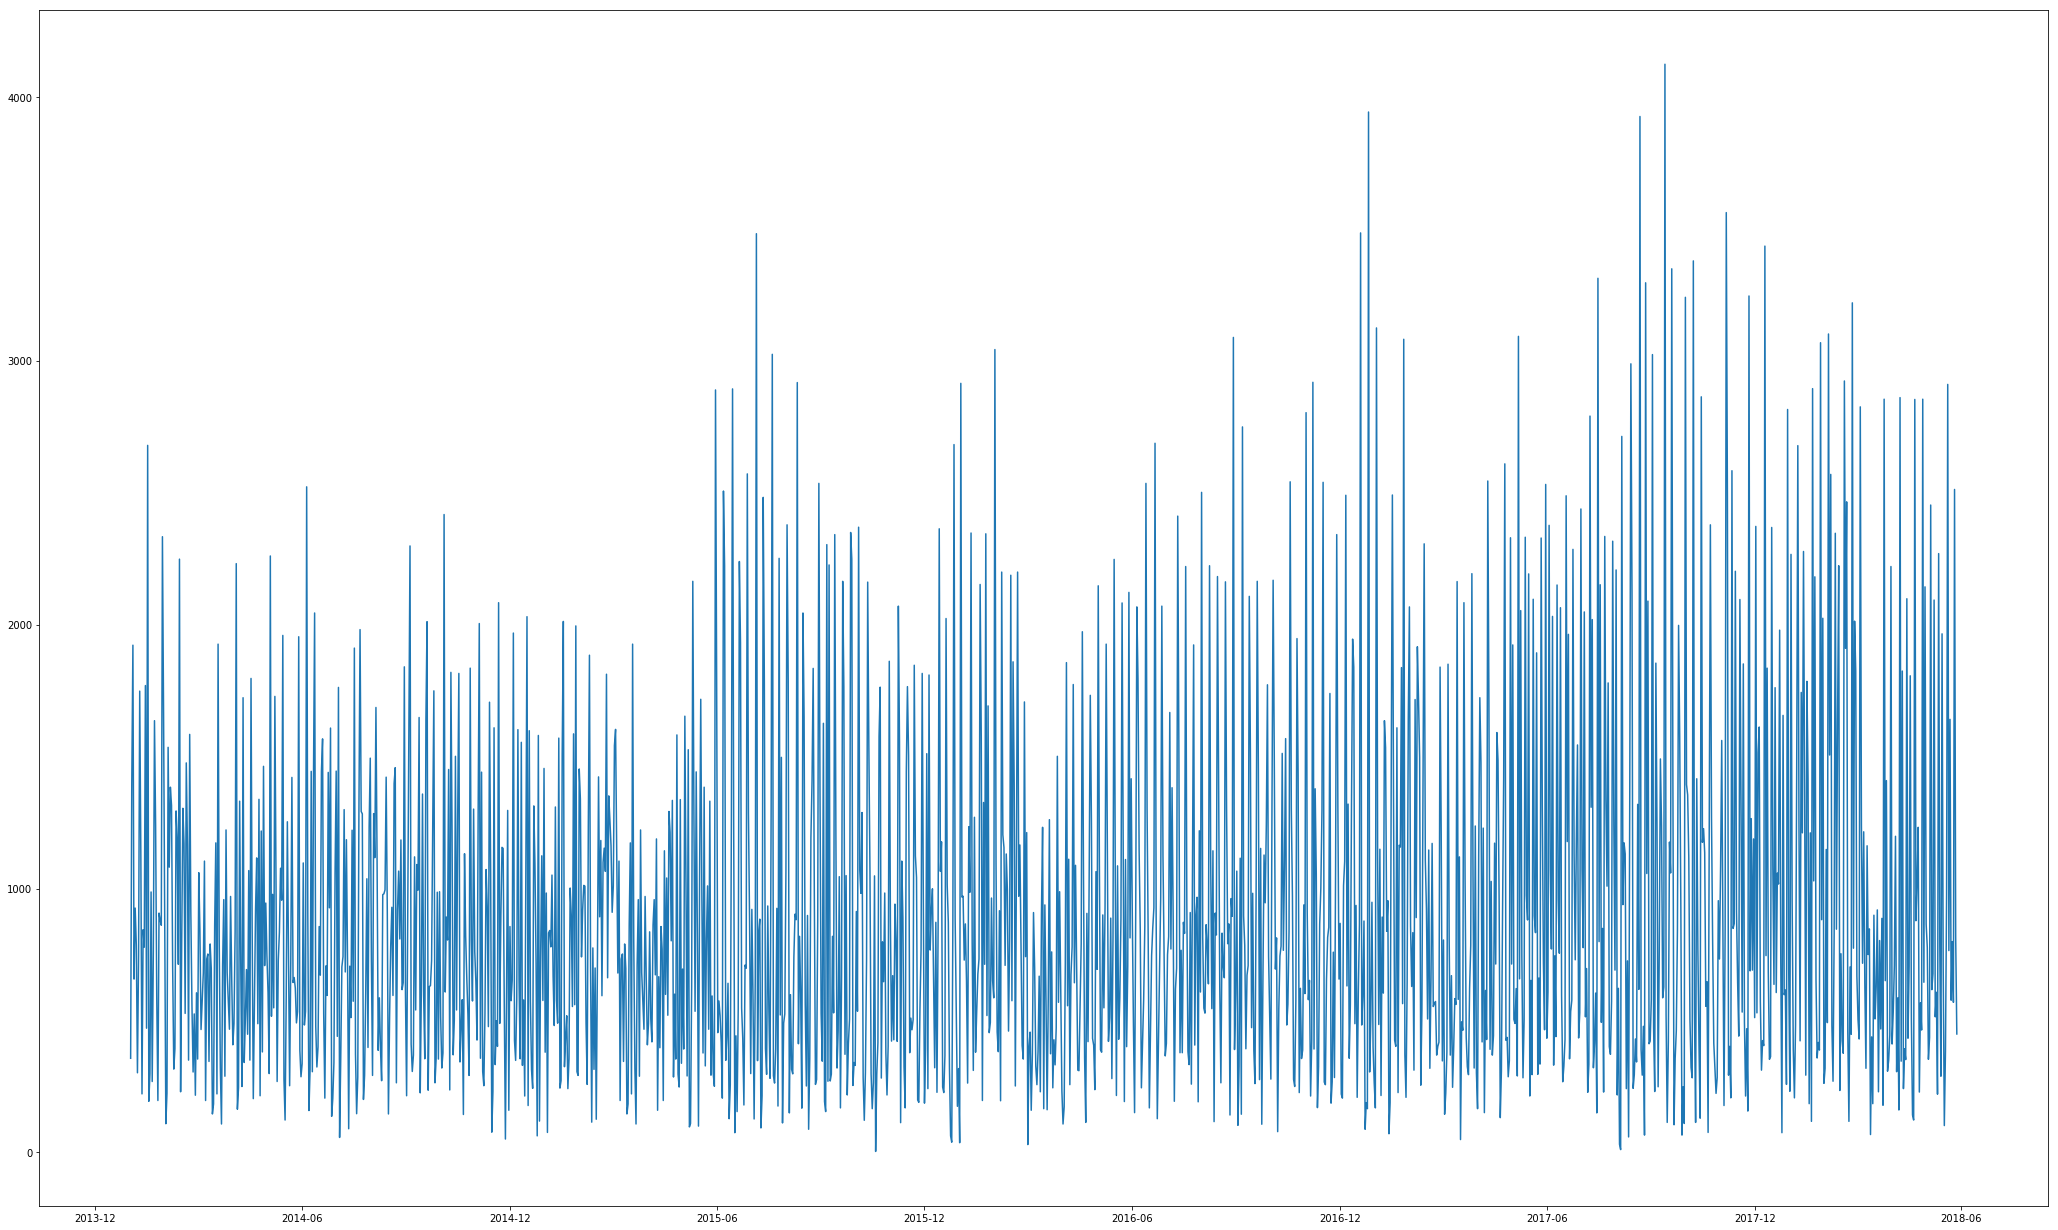

In [10]:
plt.figure(figsize=(36,22))
plt.plot(train['Date'], train['Count'])

In [11]:
# change column names to ds instead of Date and y target variable instead of Count 
# FB Prophet wants it this way

train['ds'] = train.Date
train['y'] = train.Count

# and drop the previous column names
train.drop(['Count'], axis = 1, inplace = True)
train.drop(['Date'], axis = 1, inplace = True)

__Create and fit the model__

In [13]:
model = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
model.fit(train)
future = model.make_future_dataframe(periods=148)
# the predict method will assign a value to each row in future which it names yhat
forecast = model.predict(future)

/Users/michaelweber/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/michaelweber/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


__Plot 1 to see forecast (dark blue) vs actual (black dots)__

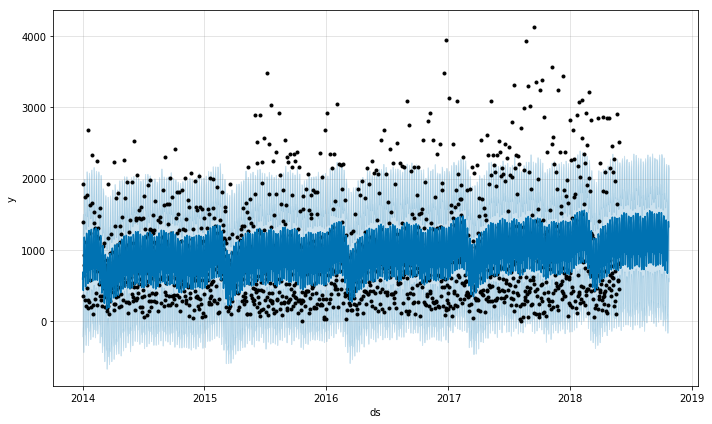

In [14]:
fig1 = model.plot(forecast)

__Plot the forecast model components - overall trend, weekly trend and yearly trend__

__notice the large dip in March arrival times in Port of LA due to CNY__

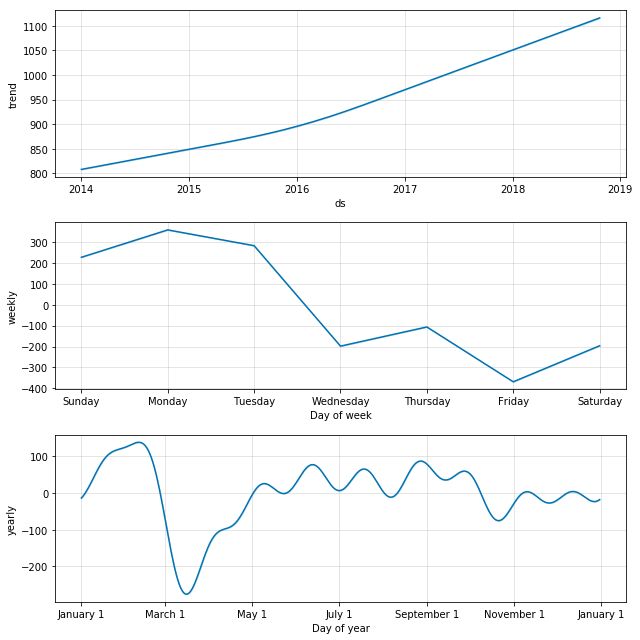

In [15]:
fig2 = model.plot_components(forecast)

__Perform Cross Validation to generate df of yhat predictions for accuracy checking__

In [16]:
df_cv = cross_validation(model, initial='1260 days', horizon = '148 days')
df_cv.head()

INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-08-05 00:00:00 and 2017-12-31 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-08-06,1113.288247,376.612784,1886.586143,2713,2017-08-05
1,2017-08-07,1415.375903,659.930223,2152.312420,939,2017-08-05
2,2017-08-08,1191.781686,512.578886,1960.132117,1173,2017-08-05
3,2017-08-09,791.719826,36.522811,1528.680754,1131,2017-08-05
4,2017-08-10,981.368774,225.628383,1696.772925,242,2017-08-05


__Check performance metrics namely RMSE and MAE__

In [17]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
162,15 days,480522.009196,693.196948,552.695696,1.367524,0.750000
14,15 days,422785.802724,650.219811,519.445240,1.356479,0.772727
163,16 days,390911.539193,625.229189,497.356069,1.244290,0.795455
15,16 days,404871.957310,636.295495,508.481997,1.260668,0.772727
311,16 days,403518.069051,635.230721,506.953002,1.254347,0.772727


__Score RMSE 836  MAE 648__

In [18]:
df_p.mae.mean(), df_p.rmse.mean()

(648.1550567952979, 836.4337204344873)

__mean of container volume 921 so off by a sufficient amount but fairly good forecast for baseline and future comparison__

In [20]:
train.y.mean()

921.8321939092604